We explore data by exploring the following
1. Essay length vs score
2. Vocabulary size vs score
3. Correlation of expert judgements

In [52]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import warnings
import os
from scipy.stats import spearmanr
warnings.filterwarnings('ignore')
%matplotlib inline

In [9]:
small_fig_size=[1,1]

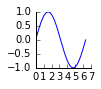

In [10]:
def saveFigure(file_name, fig, fig_size=small_fig_size, save_dir='Results'):
    # Save a figure and make it look nice
    #
    #
    
    # Make the save directory, if necessary
    if not os.path.isdir(save_dir):
        os.mkdir(save_dir)
    
    # Set the figure size
    fig.set_size_inches(fig_size[0], fig_size[1])
    
    # Build up the file name
    file_name = os.path.join(save_dir, file_name)
    
    # Get rid of grid and box
    for ax in fig.axes:
        
        ax.grid(b=False)
        
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        
        
    
    # Save as a variety of file types
    #fig.tight_layout()
    plt.show()
    plt.draw()
    
    fig.savefig(file_name+'.png',
                dpi=600)
    
    fig.savefig(file_name+'.pdf')
    
    
    
    

# Test out the plotting function
test_x = np.linspace(0, 2 * np.pi, 1.e3)
test_y = np.sin(test_x)

fig, ax = plt.subplots(1, 1)
ax.plot(test_x, test_y)

saveFigure('testFile', fig=fig)

## 0. Data import

In [11]:
filename = 'training_set_rel3.tsv'
df = pd.read_csv(filename, encoding='iso-8859-1', delimiter='\t')  ## error with utf-8 encoding
print 'Data shape: ', df.shape
df.head()

Data shape:  (12976, 28)


,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,...,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
0,1,1,"Dear local newspaper, I think effects computer...",4,4,NaN,8,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5,4,NaN,9,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4,3,NaN,7,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",5,5,NaN,10,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1,"Dear @LOCATION1, I know having computers has a...",4,4,NaN,8,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [74]:
# List of dataframes. Each dataframe contains data for each essay set.
dfs = []
dfs = [df[df['essay_set']==i+1] for i in range(8)]

# Turn into vector of features
vectorizers = [CountVectorizer() for i in range(8)]
corpuses = [dfs[i]['essay'].values for i in range(8)]
X = [vectorizers[i].fit_transform(corpuses[i]) for i in range(8)]
responses_vars = [['rater1_domain1', 'rater2_domain1','domain1_score'], ## essay set 1
                  ['rater1_domain1', 'rater2_domain1', 'domain1_score', 'rater1_domain2', 'rater2_domain2', 'domain2_score'], ## essay set 2
                  ['rater1_domain1', 'rater2_domain1','domain1_score'], ## essay set 3
                  ['rater1_domain1', 'rater2_domain1','domain1_score'], ## essay set 4
                  ['rater1_domain1', 'rater2_domain1','domain1_score'], ## essay set 5
                  ['rater1_domain1', 'rater2_domain1','domain1_score'], ## essay set 6
                  ['rater1_domain1', 'rater2_domain1','domain1_score'], ## essay set 7
                  ['rater1_domain1', 'rater2_domain1','domain1_score'] ## essay set 8
                ]
Y = [dfs[i][responses_vars[i]] for i in range(8)]
# Normalize the score to 0.0 - 1.0 scale.
for i in range(len(Y)):
    max = Y[i]['domain1_score'].max()
    min = Y[i]['domain1_score'].min()
#     max = Y[i].max()
#     min = Y[i].min()
    a = 1.0/(max-min)
    b = float(-min)/(max-min)
    Y[i]['domain1_score'] *= a
    Y[i]['domain1_score'] += b

### 0.1. Basic Stats

In [14]:
columns = ['Essay set', 'Domain', 'Min score', 'Max score', 'Mean score', 'Mean length (words)']
basic_df = pd.DataFrame(columns=columns)
for i in range(8):
    # calculate basic stats for each
    max = Y[i]['domain1_score'].max()
    min = Y[i]['domain1_score'].min()
    mean = Y[i]['domain1_score'].mean()
    mean_word_count = np.mean(X[i].sum(axis=1))
    # create new dataframe instance to append to basic_df
    new_df = pd.DataFrame([[i+1, 2, min, max, mean, mean_word_count]], columns=columns)
    basic_df = basic_df.append(new_df)
    # Essay set 2 has domain 2
    if i==1:
        max = Y[i]['domain2_score'].max()
        min = Y[i]['domain2_score'].min()
        mean = Y[i]['domain2_score'].mean()
        mean_word_count = np.mean(X[i].sum(axis=1))
        new_df = pd.DataFrame([[i+1, 2, min, max, mean, mean_word_count]], columns=columns)
        basic_df = basic_df.append(new_df)
print basic_df.round(1).to_string(index=False)

 Essay set  Domain  Min score  Max score  Mean score  Mean length (words)
         1       2          2         12         8.5                353.1
         2       2          1          6         3.4                368.1
         2       2          1          4         3.3                368.1
         3       2          0          3         1.8                105.7
         4       2          0          3         1.4                 92.4
         5       2          0          4         2.4                118.6
         6       2          0          4         2.7                150.5
         7       2          2         24        16.1                155.9
         8       2         10         60        37.0                572.7


## 1. Essay Length vs score

Essay set: 1


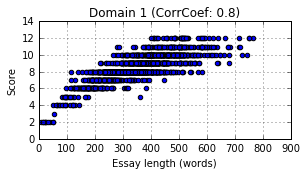

Essay set: 2


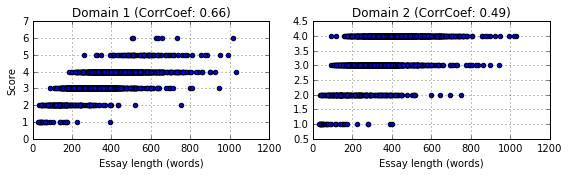

Essay set: 3


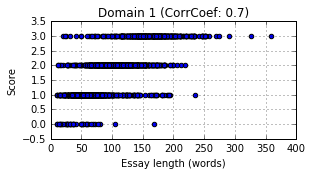

Essay set: 4


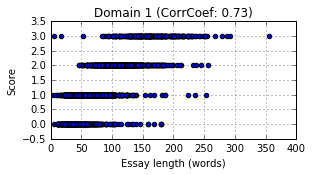

Essay set: 5


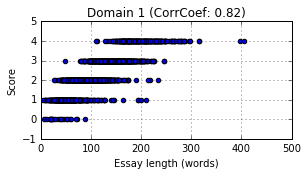

Essay set: 6


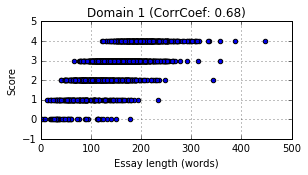

Essay set: 7


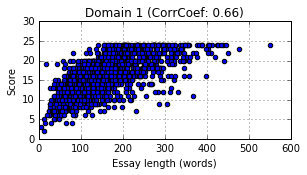

Essay set: 8


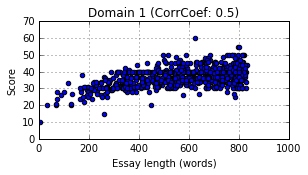

In [15]:
for i in range(8):
    print 'Essay set:', i+1
    # List of essay lengths (word counts)
    word_count = X[i].sum(axis=1)
    # List of score 
    score = Y[i]['domain1_score']
    # Corr. coef. for essay length and score
    corr_coef = np.corrcoef(np.reshape(word_count, (len(word_count), )), np.reshape(score, (len(score), )))[0, 1]
    # Plot Score vs Essay Length
    fig = plt.figure(figsize=(8, 2.5))
    ax = fig.add_subplot(1, 2, 1)
    ax.scatter(word_count, score)
    # Axis properties
    ax.set_xlim(left=0)
    ax.set_title('Domain 1 (CorrCoef: %s)' % round(corr_coef, 2))
    ax.set_xlabel('Essay length (words)')
    ax.set_ylabel('Score')
    ax.grid()
    # Essay set 2 has 2nd domain
    if i==1:
        score = Y[i]['domain2_score']
        corr_coef = corr_coef = np.corrcoef(np.reshape(word_count, (len(word_count), )), np.reshape(score, (len(score), )))[0, 1]
        ax = fig.add_subplot(1, 2, 2)
        ax.scatter(word_count, score)
        ax.set_xlim(left=0)
        ax.set_title('Domain 2 (CorrCoef: %s)' % round(corr_coef, 2))
        ax.set_xlabel('Essay length (words)')
        ax.grid()
    plt.tight_layout()
    plt.show()

Essay length and score have moderate to strong positive correlations. It is clear that a successful model will have to incorporate more than just essay length in its grading scheme. More, the correlation coefficient varies greatly from one essay set to the next, meaning that the method we choose will have to adapt for different essay types.

## 2. Vocabulary size vs score

Essay set: 1


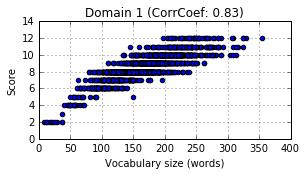

Essay set: 2


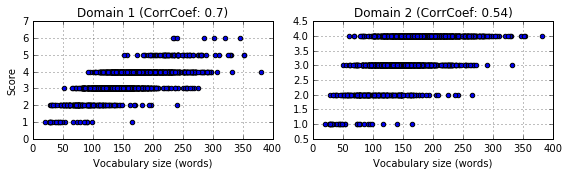

Essay set: 3


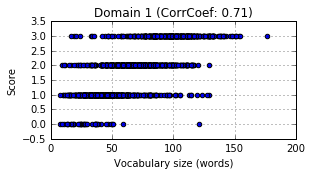

Essay set: 4


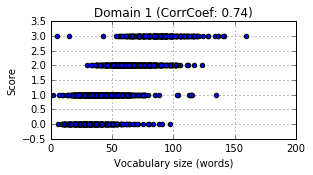

Essay set: 5


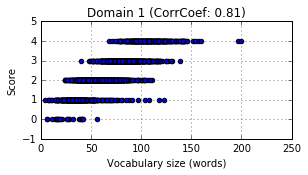

Essay set: 6


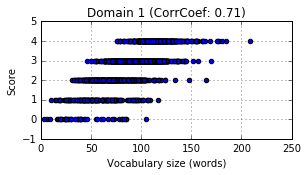

Essay set: 7


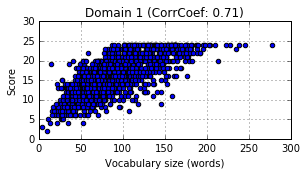

Essay set: 8


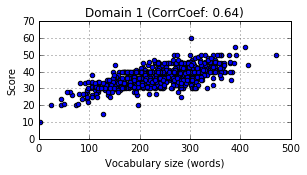

In [16]:
for i in range(8):
    print 'Essay set:', i+1
    # List of number of unique words
    vocab_count = [X[i][j, :].count_nonzero() for j in range(X[i].shape[0])]
    score = Y[i]['domain1_score']
    corr_coef = np.corrcoef(np.reshape(vocab_count, (len(vocab_count), )), np.reshape(score, (len(score), )))[0, 1]
    # Plot Score vs Vocab size
    fig = plt.figure(figsize=(8, 2.5))
    ax = fig.add_subplot(1, 2, 1)
    ax.scatter(vocab_count, score)
    # Axis properties
    ax.set_xlim(left=0)
    ax.set_title('Domain 1 (CorrCoef: %s)' % round(corr_coef, 2))
    ax.set_xlabel('Vocabulary size (words)')
    ax.set_ylabel('Score')
    ax.grid()
    # Essay set 2 has domain 2
    if i==1:
        score = Y[i]['domain2_score']
        corr_coef = np.corrcoef(np.reshape(vocab_count, (len(vocab_count), )), np.reshape(score, (len(score), )))[0, 1]
        ax = fig.add_subplot(1, 2, 2)
        ax.scatter(vocab_count, score)
        ax.set_xlim(left=0)
        ax.set_title('Domain 2 (CorrCoef: %s)' % round(corr_coef, 2))
        ax.set_xlabel('Vocabulary size (words)')
        ax.grid()
    plt.tight_layout()
    plt.show()

Vocabulary size and score have moderate - strong positive correlations. Again, there is noticable variability in the correlation between vocabulary size and essay score among different essay types, meaning that our strategy will need to be different for each set.

One limitation of the visualizations provided here is that they do not take into account misspelled words. An essay riddled with spelling mistakes will likely have a low score, but have an artificially high vocabulary size as presented here, skewing the result. We will conduct a review of literature methods of counting mispellings to incorporate this measure.

## 3. Correlation of expert judgements

Essay Set: 1


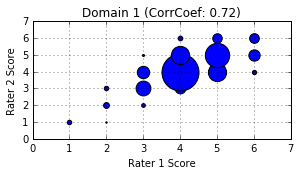

Essay Set: 2


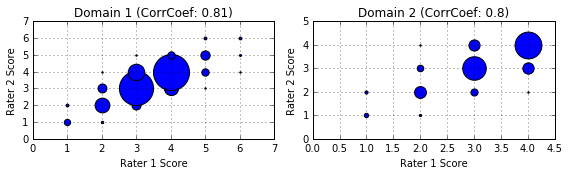

Essay Set: 3


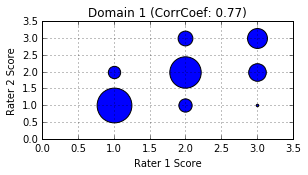

Essay Set: 4


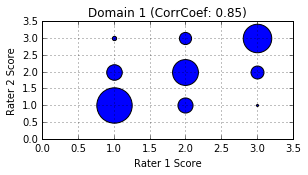

Essay Set: 5


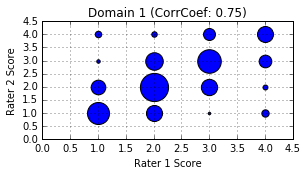

Essay Set: 6


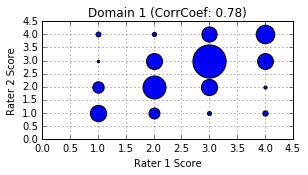

Essay Set: 7


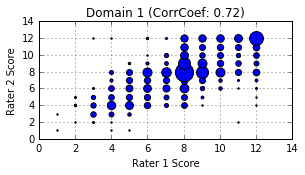

Essay Set: 8


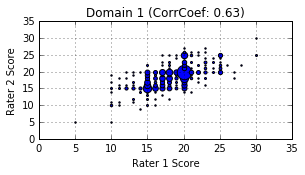

In [18]:
for i in range(8):
    corrcoef = np.corrcoef(Y[i]['rater1_domain1'], Y[i]['rater2_domain1'])[0, 1]
    print 'Essay Set:', i+1
    # Find maximum score
    max = Y[i]['rater1_domain1'].max() 
    # score_array: histogram array for scores of rater1 and rater2
    score_array = np.zeros((max, max))
    for sc1, sc2 in zip(Y[i]['rater1_domain1'], Y[i]['rater2_domain1']):
        score_array[sc1-1, sc2-1] += 1
        
    fig = plt.figure(figsize=(8, 2.5))
    ax = fig.add_subplot(1, 2, 1)
    
    # Scatter plot. Size of dot depends on how frequent it appears.
    for n in range(max):
        for m in range(max):
            ax.scatter(n+1, m+1, s=score_array[n, m]*2)
    # Axis properties
    ax.set_xlim(left=0.0)
    ax.set_ylim(bottom=0.0)
    ax.set_title('Domain 1 (CorrCoef: %s)' % round(corrcoef, 2))
    ax.set_xlabel('Rater 1 Score')
    ax.set_ylabel('Rater 2 Score')
    ax.grid()
    # Essay set 2 has domain 2
    if i==1:
        max = int((Y[i]['rater1_domain2'].max()))
        score_array = np.zeros((max, max))
        for sc1, sc2 in zip(Y[i]['rater1_domain2'], Y[i]['rater2_domain2']):
            score_array[sc1-1, sc2-1] += 1
        ax = fig.add_subplot(1, 2, 2)
        for n in range(max):
            for m in range(max):
                ax.scatter(n+1, m+1, s=score_array[n, m])
        corrcoef = np.corrcoef(Y[i]['rater1_domain2'], Y[i]['rater2_domain2'])[0, 1]
        ax.set_xlim(left=0)
        ax.set_ylim(bottom=0)
        ax.set_title('Domain 2 (CorrCoef: %s)' % round(corrcoef, 2))
        ax.set_xlabel('Rater 1 Score')
        ax.set_ylabel('Rater 2 Score')
        ax.grid()
    plt.tight_layout()
    plt.show()

While inter-grader correlation is relatively high in all cases, it is higher for essay sets with low-range discrete scores, such as essay sets 1, 2, and 3. This may be an effect of the caveat from Landauer, Laham, and Foltz (2003, reviews in Milestone 2), who warned that merely matching a computer grading method to human scorers can obscure the benefits and drawbacks of the automated scorer. Likely, this we will have to take this into account during our analysis.

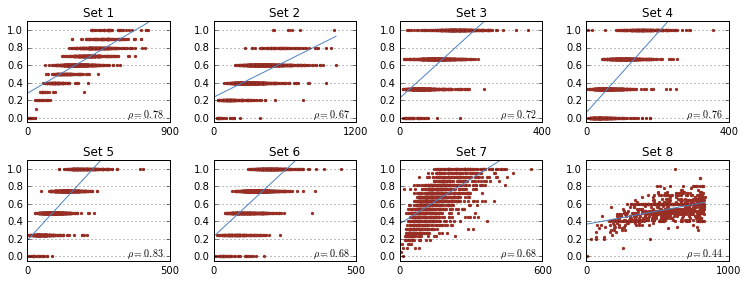

In [81]:
fig = plt.figure(figsize=(10.5, 4))
for i in range(8):
    # List of essay lengths (word counts)
    word_count = X[i].sum(axis=1)
    # List of score 
    score = Y[i]['domain1_score']
    lin_reg = LinearRegression()
    lin_reg.fit(word_count, score)
    a = lin_reg.coef_
    b = lin_reg.intercept_
    #print a, b
    # Corr. coef. for essay length and score
    #corr_coef = np.corrcoef(np.reshape(word_count, (len(word_count), )), np.reshape(score, (len(score), )))[0, 1]

    
    
    corr_coef = spearmanr(word_count, score)[0]

    # Plot Score vs Essay Length
    ax = fig.add_subplot(2, 4, i+1)
    ax.scatter(word_count, score, marker='.', color='#992E24', zorder=0)
    ax.plot([0, np.max(word_count)], [b, b+a*np.max(word_count)], color='#4E84C4', zorder=1)
    # Axis properties
    ax.set_xlim(left=0)
    text = '$\\rho= %s$' % round(corr_coef, 2)
    ax.text(0.7, 0.05, text, transform=ax.transAxes)
    ax.set_title('Set %d' % (i+1))
    #ax.set_xlabel('Essay length (words)')
    #ax.set_ylabel('Score')
    ax.set_xticks([ax.get_xticks()[0],ax.get_xticks()[-1]])
    ax.set_ylim([-0.05, np.max(score)+0.1])
    ax.grid()
plt.tight_layout()
plt.show()
saveFigure('meta_feature', fig=fig, fig_size=[10.5, 4.0])